## Feature scaling

In [1]:
import numpy as np
import matplotlib.pylab as plt

A implementation of gradient descent for 2d functions.

In [39]:
class GradientDescent:
    def __init__(self, func, func_grad):
        """Basic implementation of gradient descent for 2d functions.
        
        Args:
            func (function): 2d function to minimize.
            func_grad (function): gradient of `func`.
        """
        self.func = func
        self.func_grad = func_grad
    
    def run(self, theta0, alpha, max_iter):
        """Runs gradient descent.
        
        Args:
            theta0 (numpy.ndarray): starting point as (2,) array.
            alpha (float): learning rate.
            max_iter (int): max number of iterations.
        """
        theta = theta0
        self.gd_steps = [theta0]

        iter_ = 1 # variable to keep track of number of iteration
        while iter_ <= max_iter:
            # Gradient descent update
            theta = theta - alpha * self.func_grad(theta)

            # Update number of iterations
            iter_ = iter_ + 1
            self.gd_steps.append(theta)
    
    def plot(self, min_theta, save_to):
        """Plots function and gradient descent steps as arrows.
        
        Args:
            min_theta (numpy.ndarray): minimum of function as (2,) array.
            save_to (str): path to save plot to.
        """
        plt.clf()
        
        # Generate grid of points for which we want to
        # evaluate the function. We will center the plot
        # around the minimum.
        start_to_end = np.linalg.norm(min_theta - self.gd_steps[0])
        grid_size = 100
        theta1, theta2 = np.meshgrid(
            np.linspace(
                min_theta[0] - start_to_end,
                min_theta[0] + start_to_end,
                grid_size
            ),
            np.linspace(
                min_theta[1] - start_to_end,
                min_theta[1] + start_to_end,
                grid_size
            )
        )
        # Apply function to grid points
        cost_grid = np.array(
            [self.func(np.array(c)) for c in zip(theta1.flat, theta2.flat)]
        ).reshape(theta1.shape)
        # Plot contours
        cs = plt.contour(theta1, theta2, cost_grid, 10)
        
        # Plot starting point
        plt.plot(*self.gd_steps[0], color='r', marker='o', markersize=6)
        
        # Plot gradient descent steps as arrow
        for (start, end) in zip(self.gd_steps[:-1], self.gd_steps[1:]):
            arrow = np.concatenate([start, end - start])
            plt.quiver(*arrow, color='r', angles='xy', scale_units='xy', scale=1)
        
        # Plot minimum
        plt.plot(*min_theta, color='g', marker='o', markersize=6)

        # Save plot
        plt.clabel(cs, inline=1, fontsize=10, fmt='%1.0f')
        plt.legend()
        plt.xlabel(r'$\theta_1$')
        plt.ylabel(r'$\theta_2$')
        plt.savefig(save_to)

Let's apply gradient descent to the function $J(\theta_1, \theta_2)=9(\theta_1 - 2)^2+(\theta_2 - 1)^2$. Its minimum occurs at $\theta=\begin{pmatrix}\theta_1\\\theta_2\end{pmatrix}=\begin{pmatrix}2\\1\end{pmatrix}$. Note that $\nabla J = \begin{pmatrix}18(\theta_1-2)\\2(\theta_2-1)\end{pmatrix}$, so the update rule is $\begin{pmatrix}\theta_1\\\theta_2\end{pmatrix} := \begin{pmatrix}\theta_1\\\theta_2\end{pmatrix} - \alpha\begin{pmatrix}18(\theta_1-2)\\2(\theta_2-1)\end{pmatrix}$.

In [28]:
min_theta = np.array([2, 1])
f = lambda theta: np.dot(np.array([9, 1]), (theta - min_theta)**2)
f_grad = lambda theta: 2 * np.array([9, 1]) * (theta - min_theta)
gd = GradientDescent(f, f_grad)

Below we use $\alpha=0.1$ and start at $\begin{pmatrix}5\\5\end{pmatrix}$. Gradient descent is making large zig-zag moves along the $\theta_1$ direction about $\theta_1=2$, and making slow progress in the $\theta_2$ direction. The reason is that the gradient in the $\theta_1$ direction is much larger. This can be seen from the contours; they are elongated vertically. The first step, for instance, takes us from $\begin{pmatrix}5\\5\end{pmatrix}$ to $\begin{pmatrix}-0.4\\4.2\end{pmatrix}$, decreasing $\theta_1$ by $5.4$, and $\theta_2$ by only $0.8$. 

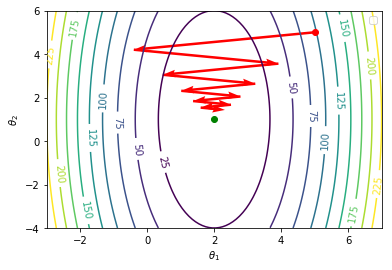

In [34]:
theta_start = np.array([5, 5])
gd.run(theta_start, 0.1, 10)
gd.plot(min_theta, "fs_zigzag.pdf")

Let's try descreasing $\alpha$ to $0.05$. The large zig-zag moves are now gone. Gradient descent makes one big step along the $\theta_1$ direction, and then takes small steps in the $\theta_2$ direction towards the minimum. Since we had to decrease $\alpha$ to avoid large moves in the $\theta_1$ direction, though, the moves in the $\theta_2$ direction are now much smaller than they need to be.

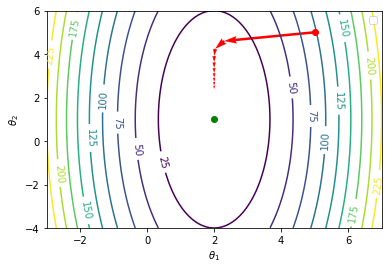

In [37]:
gd.run(theta_start, 0.05, 10)
gd.plot(min_theta, "fs_zigzag_fixed.pdf")

The problem we're facing is that $J$ has a much larger gradient along $\theta_1$ than $\theta_2$. Can we get around this somehow? Let $\tilde{\theta}_1 = 3(\theta_1-2)$, and $\tilde{\theta}_2=\theta_2-1$,
so that $J=\tilde{\theta}_1^2 + \tilde{\theta}_2^2$. We can now use gradient descent to minimize $J$ w.r.t $\tilde{\theta}_1$ and $\tilde{\theta}_2$, and simply use the rescaling to find the minimum w.r.t $\theta$. Since our function is simple enough, let's check this analytically. The minimum of $\tilde{\theta}_1^2 + \tilde{\theta}_2^2$ occurs at $\tilde{\theta}_1=\tilde{\theta}_2=0$, and with the rescaling we recover the original minimum: $\theta_1 = \tilde{\theta}_2/3+2=2$, $\theta_2 = \tilde{\theta}_1+1=1$.

The crucial point is that the gradient of $J$ along $\tilde{\theta}_1$ and $\tilde{\theta}_2$ is the same, so gradient descent can now move directly towards the minimum.

In [40]:
min_theta2 = np.array([0, 0])
f2 = lambda theta: np.dot(theta - min_theta2, theta - min_theta2)
f2_grad = lambda theta: 2 * (theta - min_theta2)
gd2 = GradientDescent(f2, f2_grad)

What's the point of this? The problem we had with $J$ was that it changes much more quickly in the $\theta_1$ direction. This is no longer the case with $\tilde{J}$.

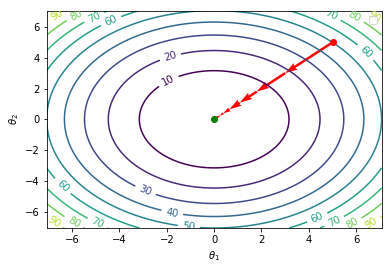

In [41]:
gd2.run(theta_start, 0.2, 10)
gd2.plot(min_theta2, "fs_scaled.pdf")